In [23]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2D Incompressible Navier-Stokes
Special geometry (periodic at $[0, 2\pi]^2$]
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} =
- \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} =
- \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

### Incompressibility condition
$ \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $

### Analytical solution (for comparison & benchmarking)
$ \begin{aligned}
u(x, y, t) &= -\cos(x)\sin(y) \cdot e^{-2\nu t} \\
v(x, y, t) &= \sin(x)\cos(y) \cdot e^{-2\nu t} \\
p(x, y, t) &= -\frac{1}{4} \left( \cos(2x) + \cos(2y) \right) \cdot e^{-4\nu t}
\end{aligned} $

In [2]:
# Parameters
nu = 0.01  # viscosity
N_coll = 10000  # Collocation points (physics)
N_ic = 1000  # Initial condition points

# Analytical solution (benchmark)
def taylor_green_u(x, y, t):
    return -np.cos(x) * np.sin(y) * np.exp(-2 * nu * t)

def taylor_green_v(x, y, t):
    return np.sin(x) * np.cos(y) * np.exp(-2 * nu * t)

def taylor_green_p(x, y, t):
    return -0.25 * (np.cos(2 * x) + np.cos(2 * y)) * np.exp(-4 * nu * t)

Example plot (analytical solution)

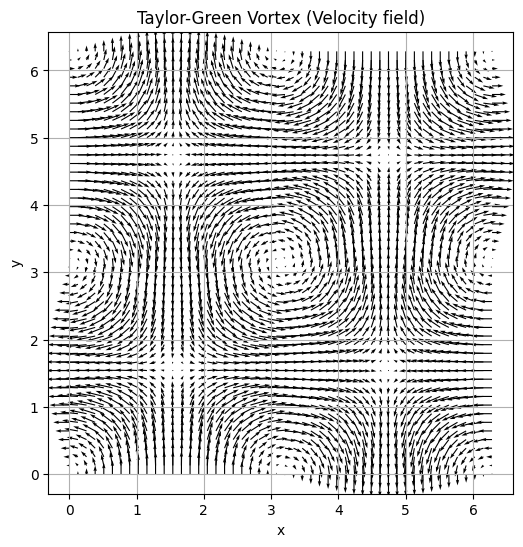

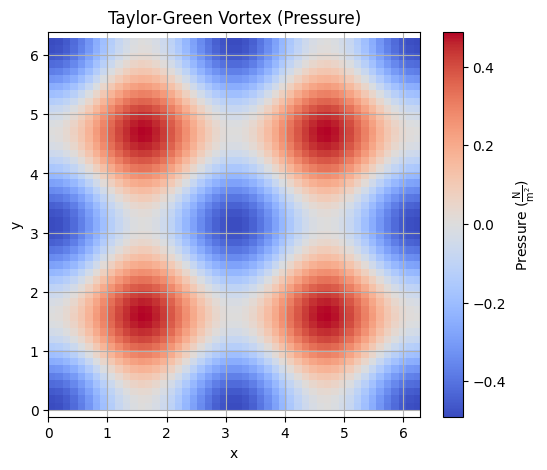

In [3]:
# Example values
N = 50
t = 0.5
x = np.linspace(0, 2*np.pi, N)
y = np.linspace(0, 2*np.pi, N)
X, Y = np.meshgrid(x, y)

u = taylor_green_u(X, Y, t)
v = taylor_green_v(X, Y, t)
p = taylor_green_p(X, Y, t)

# Plot Velocity field
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, u, v, scale=20)
plt.title('Taylor-Green Vortex (Velocity field)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

# Plot Pressure
plt.figure(figsize=(6, 5))
plt.imshow(p, extent=[0, 2*np.pi, 0, 2*np.pi], origin='lower', cmap='coolwarm')
plt.colorbar(label=r'Pressure ($\frac{\mathrm{N}}{\mathrm{m}^2}$)')
plt.title('Taylor-Green Vortex (Pressure)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

## Implementation of the PINN
Input:

$X = \begin{bmatrix} x \\ y \\ t \end{bmatrix}$

Output:

$\text{NN}(x, y, t) = \begin{bmatrix} u \\ v \\ p \end{bmatrix}$

Loss-Function:

$\mathcal{L}{\text{PINN}} = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{residues}} + 
\mathcal{L}_{\text{continuity}}$

In [4]:
class PINN(nn.Module):
    def __init__(self, hidden_dim=64):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim), # Input: x, y, t
            nn.Tanh(), # Smooth activation function & good for regularization
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)  # Output: u, v, p
        )

    def forward(self, xyt):
        return self.net(xyt) # (N, 3) -> (N, 3)

## Creating data for training
First of all we usually have a dataset (supervised learning) e.g. through measurements. However, data might be scarce and we only got data from an initial state (initial condition data). Modeling this process with a convential Neural Network almost certainly won't work. But through further physical knowledge/information we can make use of a regularization loss, which will allow our model to still grasp the (general) physical correlation in this process. This is the basic idea of a Physics-informed Neural Network.

In [5]:
def get_training_data(t_max=5):
    # Collocation points: x, y in [0, 2pi], t in [0, t_max]
    x = np.random.uniform(0, 2*np.pi, (N_coll, 1))
    y = np.random.uniform(0, 2*np.pi, (N_coll, 1))
    t = np.random.uniform(0, t_max, (N_coll, 1))
    xyt_coll = torch.tensor(np.hstack([x, y, t]), dtype=torch.float32, requires_grad=True).to(device)

    # Normal data (Initial condition: t = 0)
    x = np.random.uniform(0, 2*np.pi, (N_ic, 1))
    y = np.random.uniform(0, 2*np.pi, (N_ic, 1))
    t = np.zeros((N_ic, 1))
    u = taylor_green_u(x, y, t)
    v = taylor_green_v(x, y, t)
    xyt_ic = torch.tensor(np.hstack([x, y, t]), dtype=torch.float32).to(device)
    uv_ic = torch.tensor(np.hstack([u, v]), dtype=torch.float32).to(device)

    return xyt_coll, xyt_ic, uv_ic

## Initial condition & physics loss

In [6]:
# Physics loss
def compute_physics_loss(model, xyt_coll):
    xyt_coll = xyt_coll.clone().detach().requires_grad_(True)

    uvp = model(xyt_coll)
    u = uvp[:, 0:1]
    v = uvp[:, 1:2]
    p = uvp[:, 2:3]

    grads = torch.autograd.grad(u, xyt_coll, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]
    u_t = grads[:, 2:3]

    grads = torch.autograd.grad(v, xyt_coll, torch.ones_like(v), create_graph=True)[0]
    v_x = grads[:, 0:1]
    v_y = grads[:, 1:2]
    v_t = grads[:, 2:3]

    grads = torch.autograd.grad(p, xyt_coll, torch.ones_like(p), create_graph=True)[0]
    p_x = grads[:, 0:1]
    p_y = grads[:, 1:2]

    u_xx = torch.autograd.grad(u_x, xyt_coll, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, xyt_coll, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    v_xx = torch.autograd.grad(v_x, xyt_coll, torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = torch.autograd.grad(v_y, xyt_coll, torch.ones_like(v_y), create_graph=True)[0][:, 1:2]

    continuity = u_x + v_y

    mom_x = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    mom_y = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    loss_pde = (mom_x**2).mean() + (mom_y**2).mean() + (continuity**2).mean()
    return loss_pde

# Initial condition loss
def compute_ic_loss(model, xyt_ic, uv_ic):
    pred_uv = model(xyt_ic)[:, :2]
    return ((pred_uv - uv_ic) ** 2).mean()

## Training the PINN

In [7]:
xyt_coll, xyt_ic, uv_ic = get_training_data()

In [8]:
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
for epoch in range(5000):
    optimizer.zero_grad()
    loss_pde = compute_physics_loss(model, xyt_coll)
    loss_ic = compute_ic_loss(model, xyt_ic, uv_ic)
    loss = loss_pde + loss_ic
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5e} | PDE: {loss_pde.item():.5e} | IC: {loss_ic.item():.5e}")

Epoch 0 | Loss: 2.60963e-01 | PDE: 2.35544e-03 | IC: 2.58608e-01
Epoch 100 | Loss: 9.21269e-02 | PDE: 1.17273e-02 | IC: 8.03996e-02
Epoch 200 | Loss: 6.47081e-02 | PDE: 9.55639e-03 | IC: 5.51517e-02
Epoch 300 | Loss: 4.59884e-02 | PDE: 1.08493e-02 | IC: 3.51391e-02
Epoch 400 | Loss: 3.97155e-02 | PDE: 1.03310e-02 | IC: 2.93845e-02
Epoch 500 | Loss: 3.06507e-02 | PDE: 8.57659e-03 | IC: 2.20741e-02
Epoch 600 | Loss: 2.74087e-02 | PDE: 7.97076e-03 | IC: 1.94380e-02
Epoch 700 | Loss: 2.30232e-02 | PDE: 7.19150e-03 | IC: 1.58317e-02
Epoch 800 | Loss: 2.06744e-02 | PDE: 6.53437e-03 | IC: 1.41400e-02
Epoch 900 | Loss: 1.83484e-02 | PDE: 6.23108e-03 | IC: 1.21173e-02
Epoch 1000 | Loss: 1.62583e-02 | PDE: 5.67403e-03 | IC: 1.05842e-02
Epoch 1100 | Loss: 1.40900e-02 | PDE: 5.26246e-03 | IC: 8.82752e-03
Epoch 1200 | Loss: 1.23217e-02 | PDE: 4.79119e-03 | IC: 7.53047e-03
Epoch 1300 | Loss: 1.06876e-02 | PDE: 4.44589e-03 | IC: 6.24166e-03
Epoch 1400 | Loss: 1.92402e-02 | PDE: 7.33875e-03 | IC: 1.19

Saving model

In [13]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/model_weights.pth")

Load model

In [16]:
model = PINN().to(device)
model.load_state_dict(torch.load("models/model_weights.pth"))
model.eval()

PINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

## Plotting the model's predictions & comparison with analytical solution

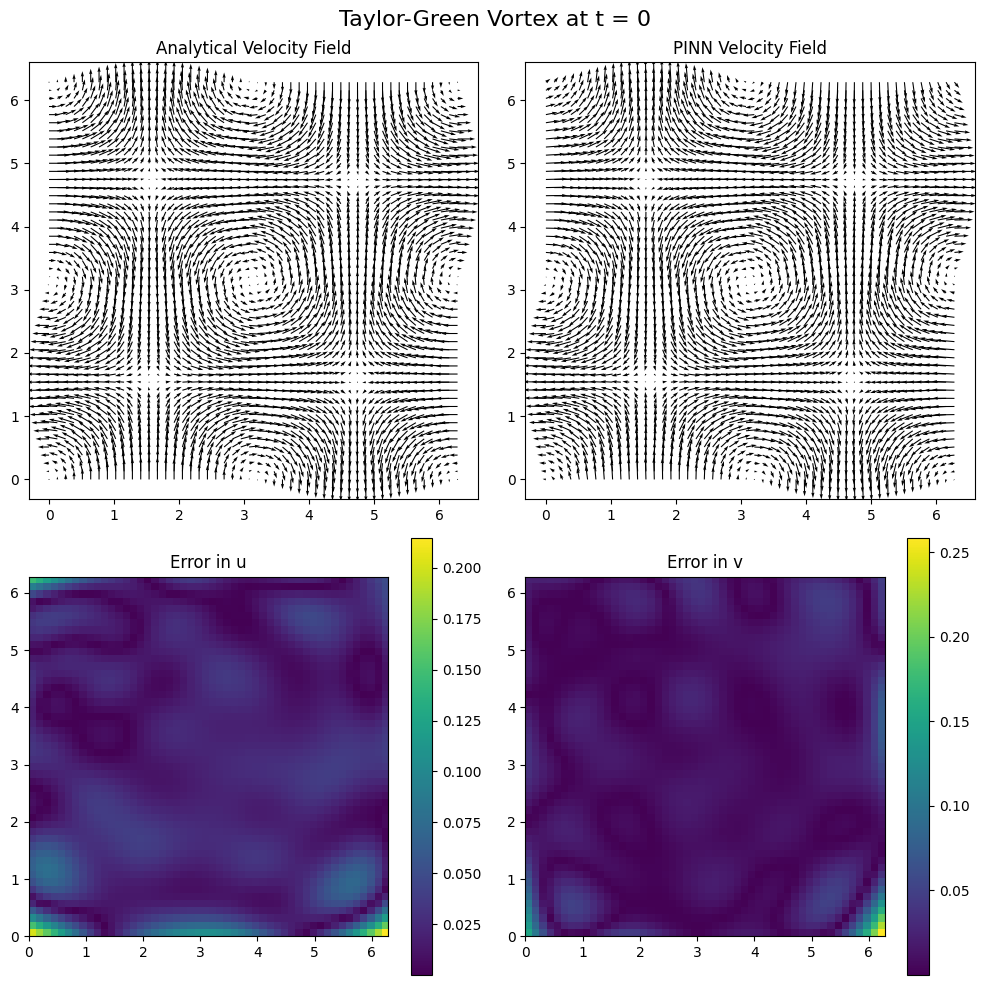

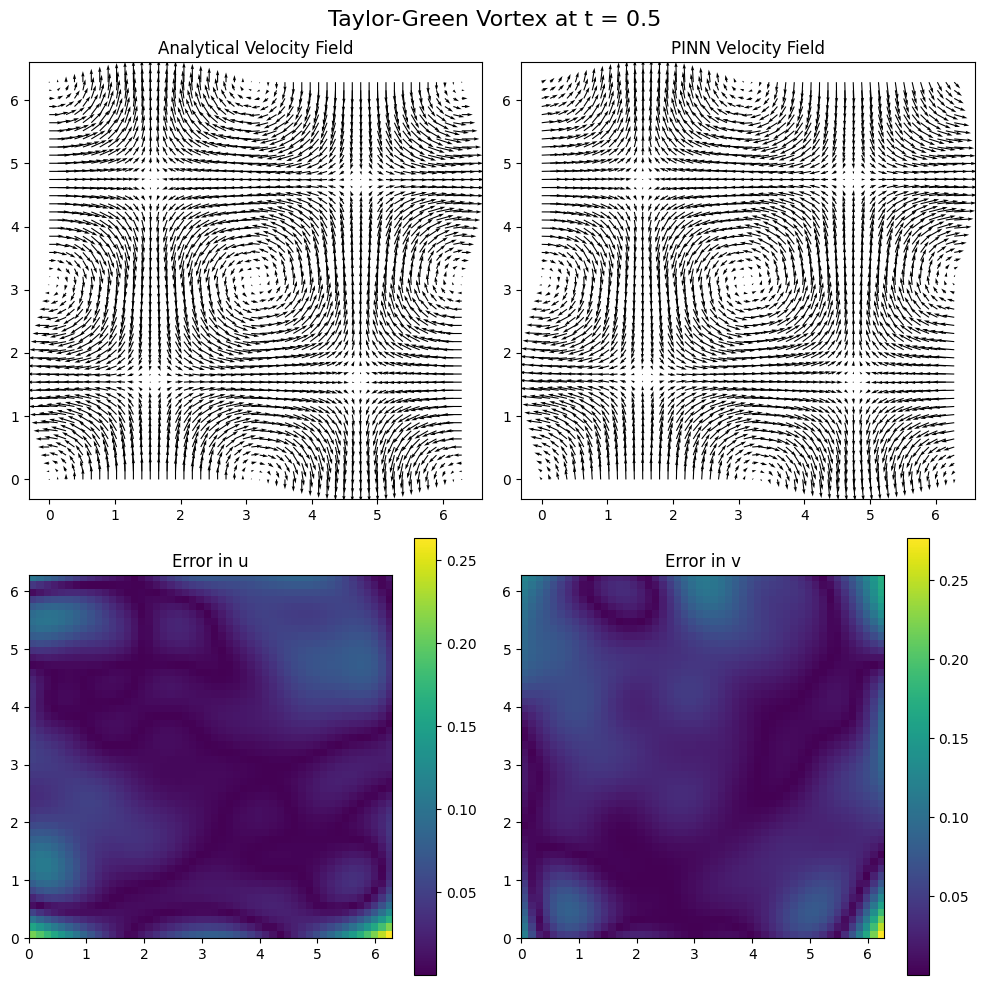

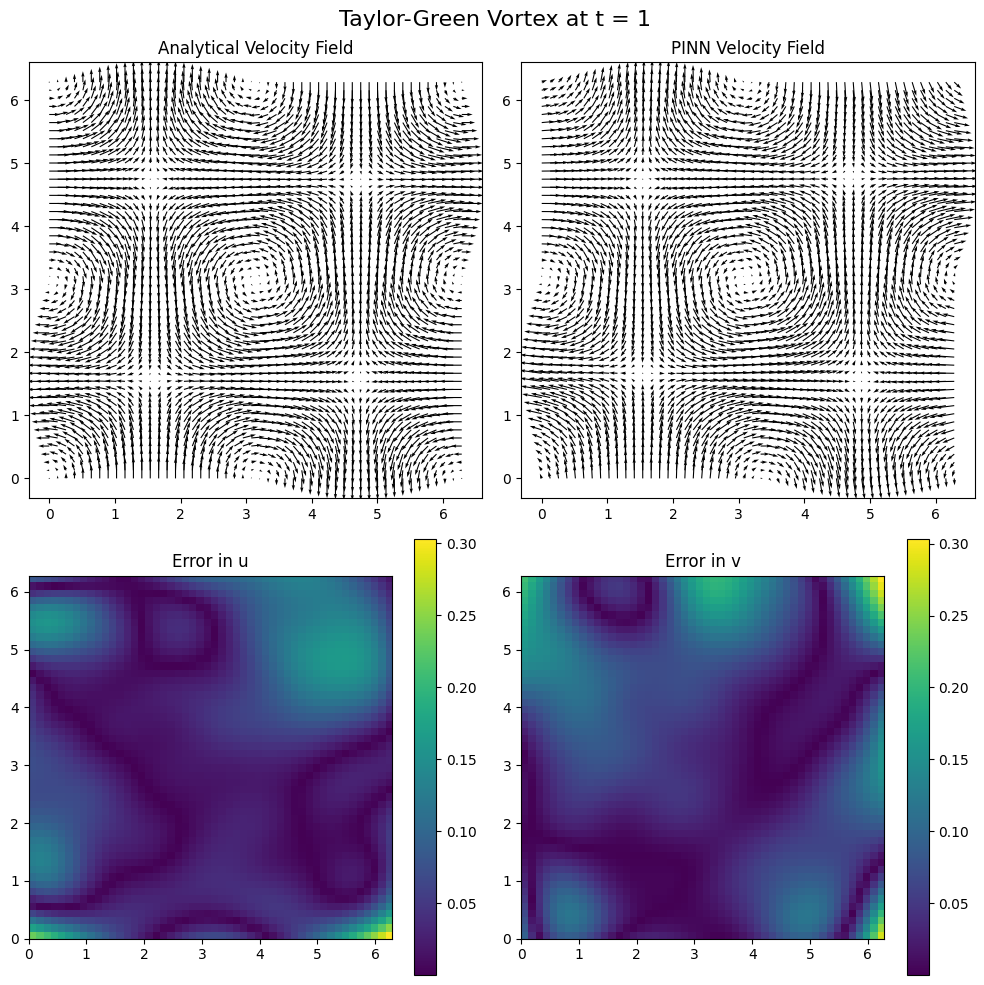

In [24]:
def plot_comparison(model, t_val=0.5):
    N = 50
    x = np.linspace(0, 2*np.pi, N)
    y = np.linspace(0, 2*np.pi, N)
    X, Y = np.meshgrid(x, y)
    T = np.full_like(X, t_val)

    xyt = torch.tensor(np.stack([X.ravel(), Y.ravel(), T.ravel()], axis=1), dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(xyt).cpu().numpy()
    U_pred = pred[:, 0].reshape(N, N)
    V_pred = pred[:, 1].reshape(N, N)

    U_true = taylor_green_u(X, Y, T)
    V_true = taylor_green_v(X, Y, T)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f"Taylor-Green Vortex at t = {t_val}", fontsize=16)
    axs[0, 0].quiver(X, Y, U_true, V_true, scale=20)
    axs[0, 0].set_title("Analytical Velocity Field")

    axs[0, 1].quiver(X, Y, U_pred, V_pred, scale=20)
    axs[0, 1].set_title("PINN Velocity Field")

    diff_u = np.abs(U_pred - U_true)
    diff_v = np.abs(V_pred - V_true)

    im1 = axs[1, 0].imshow(diff_u, extent=[0, 2*np.pi, 0, 2*np.pi])
    axs[1, 0].set_title("Error in u")
    fig.colorbar(im1, ax=axs[1, 0])

    im2 = axs[1, 1].imshow(diff_v, extent=[0, 2*np.pi, 0, 2*np.pi])
    axs[1, 1].set_title("Error in v")
    fig.colorbar(im2, ax=axs[1, 1])

    plt.tight_layout()
    plt.show()

# Some examples...
plot_comparison(model, t_val=0)
plot_comparison(model, t_val=0.5)
plot_comparison(model, t_val=1)

### Interactive slider for t

In [25]:
@interact(t_val=widgets.FloatSlider(value=0.5, min=0.0, max=5.0, step=0.1, description='t'))
def interactive_plot(t_val):
    plot_comparison(model, t_val=t_val)

interactive(children=(FloatSlider(value=0.5, description='t', max=5.0), Output()), _dom_classes=('widget-inter…